# Importing

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,4
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from scipy import stats
from scipy.stats import norm, skew
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

In [47]:
traindf = pd.read_excel('Train.xlsx')
testdf = pd.read_excel('Test.xlsx')

In [48]:
df = pd.concat([traindf,testdf], axis=0)
# df

# Exploring

In [4]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.2+ MB


# Feature Engineering

In [49]:
# Date
df['Date'] = df['Date_of_Journey'].str.split('/').str[0].astype(int)
df['Month'] = df['Date_of_Journey'].str.split('/').str[1].astype(int)
df['Year'] = df['Date_of_Journey'].str.split('/').str[2].astype(int)
df = df.drop(['Date_of_Journey'], axis=1)

# Arrival time
df['Arrival_Time'] = df['Arrival_Time'].str.split(' ').str[0]
df['Arrival_Hour'] = df['Arrival_Time'].str.split(':').str[0]
df['Arrival_Hour'] = df['Arrival_Hour'].astype(int)
df['Arrival_Minute'] = df['Arrival_Time'].str.split(':').str[1]
df['Arrival_Minute'] = df['Arrival_Minute'].astype(int)
df = df.drop(['Arrival_Time'], axis=1)

# Total stops
df['Total_Stops'] = df['Total_Stops'].replace('non-stop','0 stops')
df['Total_Stops'].fillna('0 stops', inplace=True)
df['Stops'] = df['Total_Stops'].str.split(' ').str[0]
df['Stops'] = df['Stops'].astype(int)
df = df.drop(['Total_Stops'], axis=1)

# Dep time
df['Dep_Hour'] = df['Dep_Time'].str.split(':').str[0]
df['Dep_Hour'] = df['Dep_Hour'].astype(int)
df['Dep_Minute'] = df['Dep_Time'].str.split(':').str[1]
df['Dep_Minute'] = df['Dep_Minute'].astype(int)
df = df.drop(['Dep_Time'], axis=1)

# Duration
df['Duration_Hour'] = df['Duration'].str.split(' ').str[0]
df['Duration_Hour'] = df['Duration_Hour'].str.extract('(\d+)')
df['Duration_Hour'] = df['Duration_Hour'].astype(int)
df['Duration_Minute'] = df['Duration'].str.split(' ').str[1]
df['Duration_Minute'] = df['Duration_Minute'].str.extract('(\d+)')
df['Duration_Minute'].fillna('0', inplace=True)
df['Duration_Minute'] = df['Duration_Minute'].astype(int)
df = df.drop(['Duration'], axis=1)

# Route
df['Route_1'] = df['Route'].str.split('→ ').str[0]
df['Route_2'] = df['Route'].str.split('→ ').str[1]
df['Route_3'] = df['Route'].str.split('→ ').str[2]
df['Route_4'] = df['Route'].str.split('→ ').str[3]
df['Route_5'] = df['Route'].str.split('→ ').str[4]
df = df.drop(['Route'], axis=1)
df['Route_1'].fillna('None', inplace=True)
df['Route_2'].fillna('None', inplace=True)
df['Route_3'].fillna('None', inplace=True)
df['Route_4'].fillna('None', inplace=True)
df['Route_5'].fillna('None', inplace=True)

In [35]:
# pd.set_option('display.max_columns', None)
# df

,Airline,Source,Destination,Additional_Info,Price,Date,Month,Year,Arrival_Hour,Arrival_Minute,Stops,Dep_Hour,Dep_Minute,Duration_Hour,Duration_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,No info,3897.0,24,03,2019,1,10,0,22,20,2,50,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,No info,7662.0,1,05,2019,13,15,2,5,50,7,25,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,No info,13882.0,9,06,2019,4,25,2,9,25,19,0,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,No info,6218.0,12,05,2019,23,30,1,18,5,5,25,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,No info,13302.0,01,03,2019,21,35,1,16,50,4,45,BLR,NAG,DEL,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,Kolkata,Banglore,No info,NaN,6,06,2019,20,25,1,20,30,23,55,CCU,DEL,BLR,None,None
2667,IndiGo,Kolkata,Banglore,No info,NaN,27,03,2019,16,55,0,14,20,2,35,CCU,BLR,None,None,None
2668,Jet Airways,Delhi,Cochin,No info,NaN,6,03,2019,4,25,1,21,50,6,35,DEL,BOM,COK,None,None
2669,Air India,Delhi,Cochin,No info,NaN,6,03,2019,19,15,1,4,0,15,15,DEL,BOM,COK,None,None


# Label Encoder

In [50]:
lb = LabelEncoder()
df['Airline'] = lb.fit_transform(df['Airline'])
df['Destination'] = lb.fit_transform(df['Destination'])
df['Source'] = lb.fit_transform(df['Source'])
df['Additional_Info'] = lb.fit_transform(df['Additional_Info'])
df['Route_1'] = lb.fit_transform(df['Route_1'])
df['Route_2'] = lb.fit_transform(df['Route_2'])
df['Route_3'] = lb.fit_transform(df['Route_3'])
df['Route_4'] = lb.fit_transform(df['Route_4'])
df['Route_5'] = lb.fit_transform(df['Route_5'])

# Data Preparation

In [51]:
df_train = df[:10683]
df_test = df[10683:]
df_test = df_test.drop(['Price'], axis=1)

In [52]:
X = df_train.drop(['Price'], axis=1)
y = df_train.Price

# Modelling

## Linear Regression

In [53]:
lr = LinearRegression()
kfolds = KFold(n_splits=50, shuffle=True, random_state=100)

In [54]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return rmse
benchmark_model = make_pipeline(RobustScaler(), lr).fit(X=X, y=y)
cv_rmse(benchmark_model).mean()

3226.992850862331

## Ridge Regression

In [43]:
def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(), RidgeCV(alphas=[k], cv=kfolds)).fit(X, y)
    ridge_rmse = cv_rmse(ridge_model).mean()
    return ridge_rmse

r_alphas = [.0001, .0003, .0005, .0007, .0009, .01, .05, .1, .3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]
ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

,RMSE
0.0001,3226.992849
0.0003,3226.992846
0.0005,3226.992842
0.0007,3226.992839
0.0009,3226.992836
0.0100,3226.992682
0.0500,3226.992009
0.1000,3226.991168
0.3000,3226.987820
1.0000,3226.976288


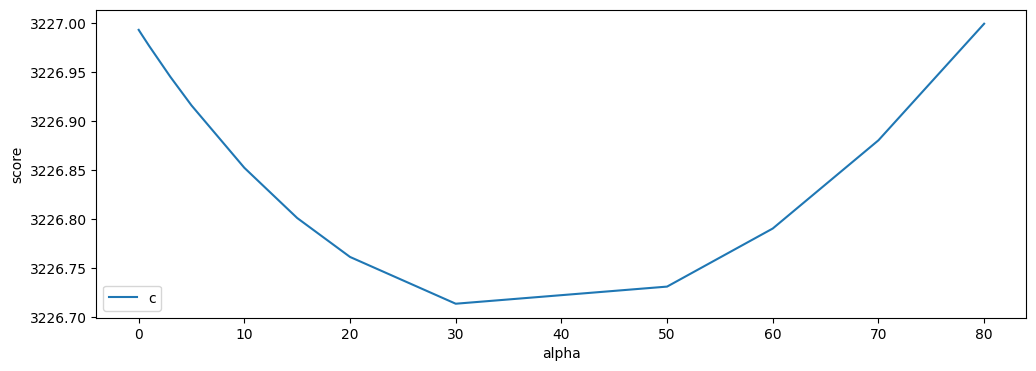

In [44]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')
ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

In [45]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge_model2 = make_pipeline (RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds)).fit(X, y)
cv_rmse (ridge_model2).mean()

3226.7964426431213

## XGB

In [55]:
xgb3 = XGBRegressor (learning_rate=0.1, n_estimators=200, max_depth=10,
                     min_child_weight=6,gamma=0, subsample=0.7,
                     colsample_bytree=0.8, objective='reg:linear',
                     nthread=4, scale_pos_weight=1, seed=27, reg_alpha=0.00006)
xgb_fit = xgb3.fit(X, y)

[08:16:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [57]:
cv_rmse(xgb_fit).mean()

[08:17:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:01] WARNING: ../src/objective/regression_

1319.0518669470202

XGB shows minimum RMSE

# Predictions

In [66]:
df_test_xgb = df_test[['Airline','Source','Destination','Additional_Info','Date','Month','Year','Arrival_Hour','Arrival_Minute','Stops','Dep_Hour','Dep_Minute','Duration_Hour','Duration_Minute','Route_1','Route_2','Route_3','Route_4','Route_5']]
preds_1 = xgb_fit.predict(df_test_xgb)
testdf['Price'] = preds_1
testdf.to_excel('flight_prices.xlsx',index=False)